In [1]:
#setup libraies
import tensorflow as tf
import os
import cv2
import imghdr
from matplotlib import pyplot as plt 
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers
from tensorflow import keras 

In [2]:
data_dir = 'C:/Users/nooro/Deep learning MU/CNN_project/Data'

In [49]:
image_ext = ['jpeg','jpg','bmp','png']
#LOOP THROUGH EVERY SINGL IMAGE in the data dir and remove them by using doggy image script
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_ext:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            

In [4]:
def augment(image, label):
    new_height = new_width = 32
    image = tf.image.resize(image, (new_height,new_width))
    
    #if tf.random.uniform((), minval=0,maxval=1) < 0.1:
        #image = tf.tile(tf.image.rgb_to_grayscale(image), [1,1,1,3])
    
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.2)
    
    image = tf.image.random_flip_left_right(image)#50%
    #image = tf.image.random_flip_up_down(image)#50%
    return image, label

In [50]:
image_dataset_from_directory??

Object `image_dataset_from_directory` not found.


In [8]:
 #load data
data = tf.keras.utils.image_dataset_from_directory(data_dir) #هنا بنينا داتا pipeline بالتوول الجاهزه بتاعت كيراس

Found 884 files belonging to 2 classes.


In [7]:
data = data.map(augment,num_parallel_calls= tf.data.AUTOTUNE)
#x = images y = labels || data.map allows us to perform the transformation in the pipeline
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:
data_iterator = data.as_numpy_iterator()
data_iterator

In [10]:
batch = data_iterator.next() # this graping one batch of the data

In [11]:
print(len(batch)) #2 images and labels
print(batch[0].shape) #images represeted as numpy arrays
print(batch[1]) #good news = 0, bad news = 1

2
(32, 256, 256, 3)
[0 0 1 0 1 0 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0]


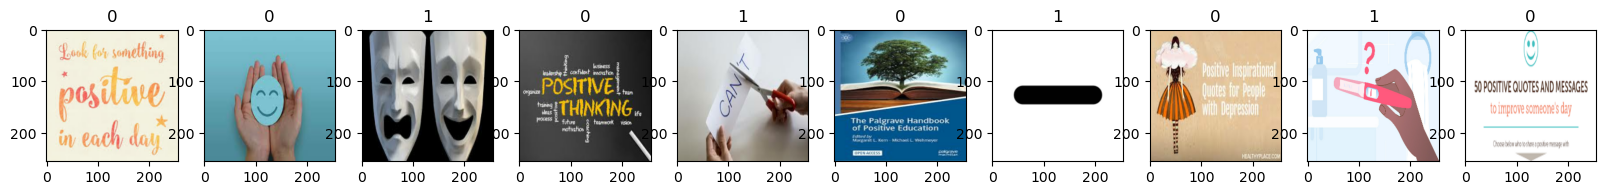

In [13]:
#for the sack of knowing which class is good news and which is bad
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [14]:
print(batch[0].max())
print(batch[0].min())

255.0
0.0


In [15]:
#Scale the data from 1 --> 0 
scaled = batch[0] / 255
print(scaled.max())
print(scaled.min())

1.0
0.0


In [16]:
scaled_iterator = data.as_numpy_iterator()

In [17]:
batch = scaled_iterator.next()[0].max()

In [18]:
len(data)

28

In [53]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1
print(train_size)
print(val_size)
print(test_size)

19
6
3


In [54]:
train_size+val_size+test_size

28

In [21]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [22]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3))) #16 filters 3*3 pixels moving 1pixil per move (relu) = anything less than zero we take it to zero and preserved to positive values
model.add(MaxPooling2D()) # it's gonna take the max value after the relu activation and return it back it will condens the output

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten()) #filters will be the last channel so we gonna condense the rows and width and number of output will be channel value, then we wanna condensed down to a singel value by Flatten it

#output
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #singel output will be between 0 and 1 using sigmoid to classiefy

In [23]:
#tf.losses.BinaryCrossentropy for Binary classification problems
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [26]:
logdir = 'logs' # to save all the training outputs

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=32, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/32
19/19 [==============================] - 14s 647ms/step - loss: 62.3515 - accuracy: 0.5164 - val_loss: 0.6789 - val_accuracy: 0.5312
Epoch 2/32
19/19 [==============================] - 13s 662ms/step - loss: 0.6693 - accuracy: 0.5625 - val_loss: 0.6763 - val_accuracy: 0.5688
Epoch 3/32
19/19 [==============================] - 13s 661ms/step - loss: 0.6351 - accuracy: 0.6414 - val_loss: 0.6044 - val_accuracy: 0.6125
Epoch 4/32
19/19 [==============================] - 13s 667ms/step - loss: 0.5695 - accuracy: 0.6826 - val_loss: 0.6382 - val_accuracy: 0.6562
Epoch 5/32
19/19 [==============================] - 13s 668ms/step - loss: 0.4702 - accuracy: 0.7418 - val_loss: 0.7065 - val_accuracy: 0.7250
Epoch 6/32
19/19 [==============================] - 15s 762ms/step - loss: 0.4276 - accuracy: 0.7796 - val_loss: 0.5520 - val_accuracy: 0.6875
Epoch 7/32
19/19 [==============================] - 15s 774ms/step - loss: 0.3952 - accuracy: 0.8158 - val_loss: 0.5451 - val_accuracy: 0.787

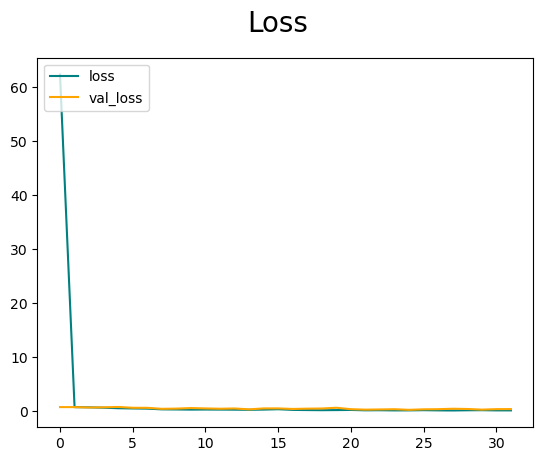

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label='loss')
plt.plot(hist.history['val_loss'], color = 'orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

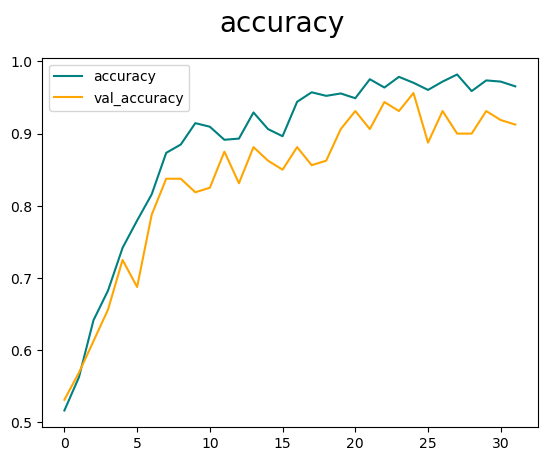

In [31]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label='val_accuracy')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [32]:
#Evalute Performance Stage
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
len(test)

3

In [34]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 393ms/step


In [35]:
print(f'Precsion:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precsion:0.914893627166748, Recall:0.8775510191917419, Accuracy:0.8958333134651184


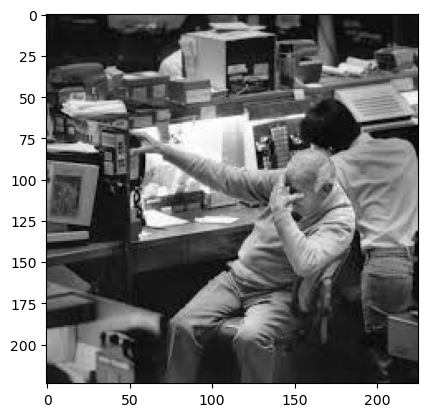

In [36]:
img = cv2.imread('sadtest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

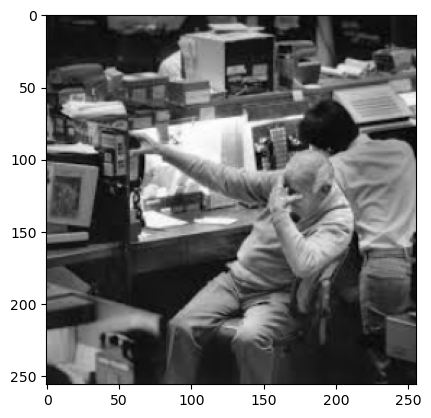

In [37]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [38]:
resize.shape

TensorShape([256, 256, 3])

In [39]:
#  احنا عملنا الخطوه دي عشان الموديل بتاعنا مستني مننا الداتا تدخله في صورة مجموعة صور مش صوره واحده عشان كده عملنا اكسباند الدايمنشنز وكده ده انكابسوليت للداتا في ليست او اراي جديده
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [40]:
yhat = model.predict(np.expand_dims(resize/255, 0)) #وطبعاً هنا قسمنها على 255 عشان نعمل اسكال

1/1 [==============================] - 0s 220ms/step


In [41]:
yhat

array([[0.46551254]], dtype=float32)

In [42]:
if yhat > 0.5:
        print(f'Predicted class is Happy')
else:
        print(f'Predicted class is Sad')


Predicted class is Sad


In [43]:
from tensorflow.keras.models import load_model

In [44]:
new_model = load_model(os.path.join('CNN_project','CNN_ClassifiacationHappySad.h5')) 

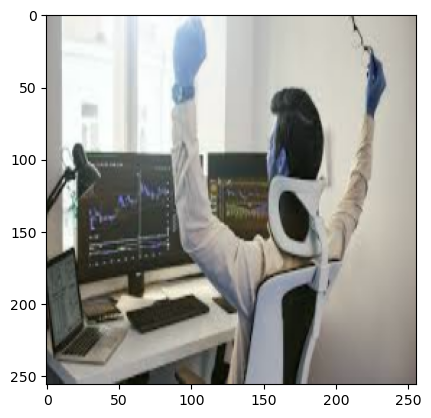

In [45]:
new_img = cv2.imread('happytest.jpg')
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
resize_img = tf.image.resize(new_img, (256,256))
plt.imshow(resize_img.numpy().astype(int))
plt.show()

In [46]:
new_model.predict(np.expand_dims(resize_img/255, 0))

1/1 [==============================] - 0s 221ms/step


array([[0.99656236]], dtype=float32)

In [47]:
yhat_new = new_model.predict(np.expand_dims(resize_img/255, 0))

1/1 [==============================] - 0s 78ms/step


In [48]:
if yhat_new > 0.5:
        print(f'Predicted class is Happy')
else:
        print(f'Predicted class is Sad')


Predicted class is Happy
